In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import  RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import silhouette_score, confusion_matrix
from sklearn.decomposition import PCA
from RFBDoSBC.GetAndPrepareData import *
from RFBDoSBC.modelPreparation import *
from RFBDoSBC.modelEvaluation import *
from RFBDoSBC.plotData import *
from RFBDoSBC.utility import *


In [2]:

rad_mom_gen = res_pT_iterator()
text_results = {}

In [3]:
rad, ptm = next(rad_mom_gen)
msg("Analyzing jets with R=%1.1f and p_T hardmin=%d"%(rad, ptm))


JEB: Analyzing jets with R=0.2 and p_T hardmin=10


In [4]:
best_params = loadBestParameters(rad, ptm)
best_params_lowpt = loadBestParameters(rad, ptm, True)
rfModel = [makeRandomForest(best_params) for _ in range(10)]
rfModelLowpt = [makeRandomForest(best_params_lowpt) for _ in range(10)]

batch_num = 0
feat_imp = {}

In [5]:
print(best_params_lowpt)
print(best_params)

{'n_estimators': 200, 'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 100, 'min_samples_split': 4, 'min_weight_fraction_leaf': 0.1, 'max_features': 'auto', 'max_leaf_nodes': 1000, 'min_impurity_decrease': 0.0, 'class_weight': {1: 1, 2: 1, 3: 4}, 'max_samples': 0.9, 'oob_score': True, 'random_state': 42, 'n_jobs': -1}
{'n_estimators': 200, 'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 100, 'min_samples_split': 4, 'min_weight_fraction_leaf': 0.1, 'max_features': 'auto', 'max_leaf_nodes': 1000, 'min_impurity_decrease': 0.0, 'max_samples': 0.9, 'oob_score': True, 'random_state': 42, 'n_jobs': -1}


In [6]:
dataGen = DataPipelineBatch(f"Analysis_Code/Generator Output/merged-ML-output-LOWSTATS-Rparam-{rad}-pThardmin-{ptm}.0.csv", ptm, True, False)




In [7]:
fig, ax = plt.subplots(8+15, 1, figsize=(15,40));
fig1, ax1 = plt.subplots(8+15, 1, figsize=(15,40));


In [ ]:
text_results[f'R{rad}pt{ptm}'] = {}


In [ ]:

do_plotting = False
low_pt = False

start_time = time.time()

while batch_num<12:
    try:
        print(f"Doing batch_num {batch_num}")
        
        train, test = next(dataGen)
        if low_pt:
            trainLowpt = train.loc[train['p_T']<(100+(ptm/10-1)*20)]

        #if(batch_num==1):
        #    sns.pairplot(data=train, hue='Label_Name')

        i=0

        X, Y = split_feat_label(train)
        if low_pt:
            XLowpt, YLowpt = split_feat_label(trainLowpt)

        # Test PCA

        pca = PCA()

        pca.fit(X)

        print(f"PCA variances: {pca.explained_variance_ratio_} \n Components: {pca.components_}")
        text_results[f'R{rad}pt{ptm}']['pca'] = [(pca.explained_variance_ratio_[i], dict(zip(X.columns,pca.components_[i]))) for i in range(len(X.columns))]

        if low_pt:
            pca_low = PCA()

            pca_low.fit(XLowpt)

            print(f"PCA variances: {pca_low.explained_variance_ratio_} \n Components: {pca_low.components_}")
            text_results[f'R{rad}pt{ptm}']['pca_low'] = [(pca_low.explained_variance_ratio_[i], dict(zip(X.columns,pca_low.components_[i]))) for i in range(len(X.columns))]

        rfModel[batch_num] = doRandomForestFit(X, Y, rfModel[batch_num], batch_num)
        if low_pt:
            rfModelLowpt[batch_num] = doRandomForestFit(XLowpt, YLowpt, rfModelLowpt[batch_num], batch_num)


        batch_num+=1
    except StopIteration:
        print(f"No more data in batch num: {batch_num}, trimming forest.")
        rfModel = rfModel[:batch_num]
        if low_pt:
            rfModelLowpt = rfModelLowpt[:batch_num]
        break
train_and_plot_time = time.time()-start_time

save_time = time.time()-train_and_plot_time

print(f"It took {train_and_plot_time}s to train and plot. It took {save_time}s to save")

Doing batch_num 0
PCA variances: [9.91510651e-01 7.65314051e-03 6.98650838e-04 1.37557282e-04] 
 Components: [[ 9.4434945e-03 -6.3002110e-04  4.5662988e-02  9.9891198e-01]
 [-1.4487138e-03 -5.0011696e-03  9.9894363e-01 -4.5653868e-02]
 [-9.5001310e-01 -3.1207281e-01 -2.5334004e-03  8.9001954e-03]
 [-3.1206387e-01  9.5004457e-01  4.4567250e-03  3.3456683e-03]]
JEB: Fitting to data for batch 0.
Doing batch_num 1
PCA variances: [9.91448297e-01 7.70371011e-03 7.09382274e-04 1.38610414e-04] 
 Components: [[ 9.4991056e-03 -5.8382750e-04  4.5915112e-02  9.9890012e-01]
 [-1.4268084e-03 -4.7177048e-03  9.9893379e-01 -4.5905825e-02]
 [-9.4877356e-01 -3.1582087e-01 -2.4354169e-03  8.9497566e-03]
 [-3.1581098e-01  9.4880706e-01  4.1845813e-03  3.3655167e-03]]
JEB: Fitting to data for batch 1.
Doing batch_num 2
PCA variances: [9.91219120e-01 7.90905967e-03 7.27197313e-04 1.44622944e-04] 
 Components: [[ 9.7995792e-03 -5.6475401e-04  4.6323188e-02  9.9887866e-01]
 [-1.5130822e-03 -4.6277004e-03  9.9

In [ ]:
print(X.head())

             Area  Angularity  Mean-p_T    p_T_1
3237302  0.068159    0.152350  0.388521  1.34686
3261067  0.109255    0.123020  0.521013  3.03148
3221976  0.110258    0.132003  0.512632  2.41645
3200564  0.100234    0.132606  0.462895  1.63034
3230611  0.103241    0.136564  0.894088  3.03441


In [ ]:
train, test = DataPipeline(f"Analysis_Code/Generator Output/merged-ML-output-LOWSTATS-Rparam-{rad}-pThardmin-{ptm}.0.csv", ptm, 200000000, True)
if low_pt:
    trainLowpt = train.loc[train['p_T']<100]

X, Y = split_feat_label(train)

if low_pt:
    XLowpt, YLowpt = split_feat_label(trainLowpt)


In [ ]:
oracle = doOracleFit(X, rfModel, rad, ptm)
if low_pt:
    oracleLowpt = doOracleFit(XLowpt, rfModelLowpt, rad, ptm, True)

JEB: Initializing Oracle and fitting to rfModel's predictions
(9, 1888136) [[1 1 2 ... 1 2 1]
 [1 1 2 ... 1 2 1]
 [1 1 2 ... 1 2 1]
 ...
 [1 1 2 ... 1 2 1]
 [1 1 2 ... 1 2 1]
 [1 1 2 ... 1 2 1]]
(1888136,) 0          1
1          1
2          2
3          2
4          2
          ..
1888131    2
1888132    1
1888133    1
1888134    2
1888135    1
Length: 1888136, dtype: int64
[1 2]


In [ ]:
from sklearn.metrics import accuracy_score

Xtest, Ytest = split_feat_label(test)
oracle_test_predictions = oracle.predict(Xtest)
oracle_acc = accuracy_score(Ytest, oracle_test_predictions)
print(f"Oracle accuracy: {oracle_acc}")
text_results[f'R{rad}pt{ptm}']['oracle_acc'] = oracle_acc

ave_rf_acc=0

for i,rf in enumerate(rfModel):
    rf_predictions = rf.predict(Xtest)
    rf_acc = accuracy_score(Ytest, rf_predictions)
    ave_rf_acc+=rf_acc
    print(f"Random Forest accuracy, model {i}: {rf_acc}")
ave_rf_acc/=(i+1)

text_results[f'R{rad}pt{ptm}']['ave_rf_acc'] = ave_rf_acc



if low_pt:
    testLowpt = test.loc[test['p_T']<100]
    XtestLowpt, YtestLowpt = split_feat_label(testLowpt)
    oracleLowpt_test_predictions = oracleLowpt.predict(XtestLowpt)
    oracle_acc_low = accuracy_score(YtestLowpt, oracleLowpt_test_predictions)
    print(f"Oracle Low p_T accuracy: {oracle_acc_low}")
    text_results[f'R{rad}pt{ptm}']['oracle_acc_low'] = oracle_acc_low

    ave_rf_acc_low = 0

    for i,rf in enumerate(rfModelLowpt):
        rf_predictions = rf.predict(XtestLowpt)
        rf_acc_low = accuracy_score(YtestLowpt, rf_predictions)
        ave_rf_acc_low+=rf_acc_low
        print(f"Random Forest accuracy, model {i}: {rf_acc_low}")
    ave_rf_acc_low/=(i+1)

    text_results[f'R{rad}pt{ptm}']['ave_rf_acc_low'] = ave_rf_acc_low




Oracle accuracy: 0.5662664130126219
Random Forest accuracy, model 0: 0.5650376879631552
Random Forest accuracy, model 1: 0.5662473465894405
Random Forest accuracy, model 2: 0.5652262337035044
Random Forest accuracy, model 3: 0.5673489621510315
Random Forest accuracy, model 4: 0.5653681726316324
Random Forest accuracy, model 5: 0.5663024273675201
Random Forest accuracy, model 6: 0.5659359283441447
Random Forest accuracy, model 7: 0.5667896804043776
Random Forest accuracy, model 8: 0.5670481363630586


JEB: Computing feature importances and other model statistics.
JEB: Feature rankings:
1. Area (0.687038)
2. p_T_1 (0.215924)
3. Angularity (0.078341)
4. Mean-p_T (0.018697)
JEB: Plotting feature importances.
JEB: Plot distribution of importances.
JEB: Computing performance metrics
predictions_train=[array([1, 2, 2, ..., 1, 2, 1]), array([1, 2, 2, ..., 2, 2, 2])]
population_rates_train=[0.4574306578932035, 0.6758614700459317]
predictions_test=[array([1, 2, 2, ..., 2, 2, 1]), array([2, 2, 2, ..., 1, 2, 2])]
population_rates_test=[0.45624486616026894, 0.6739790380571196]
JEB: Computing feature importances and other model statistics.
JEB: Feature rankings:
1. Area (0.698311)
2. p_T_1 (0.201824)
3. Angularity (0.088828)
4. Mean-p_T (0.011037)
JEB: Plotting feature importances.
JEB: Plot distribution of importances.
JEB: Computing performance metrics
predictions_train=[array([1, 2, 2, ..., 1, 2, 1]), array([1, 2, 2, ..., 2, 2, 2])]
population_rates_train=[0.48984063048584237, 0.6456664643852

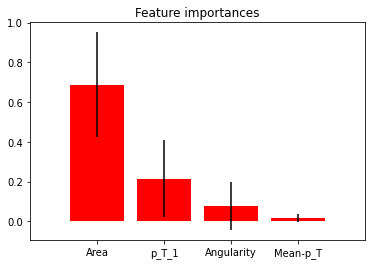

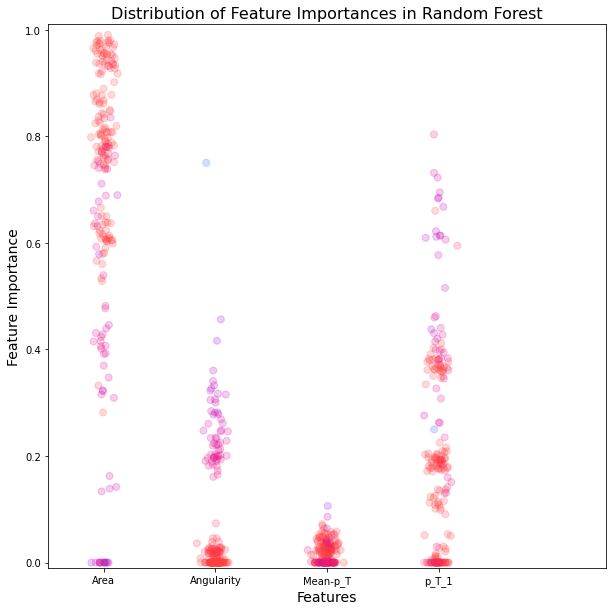

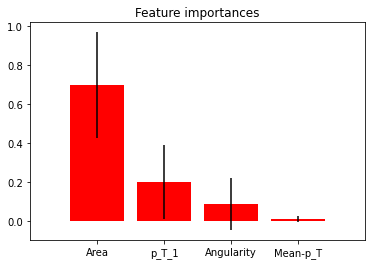

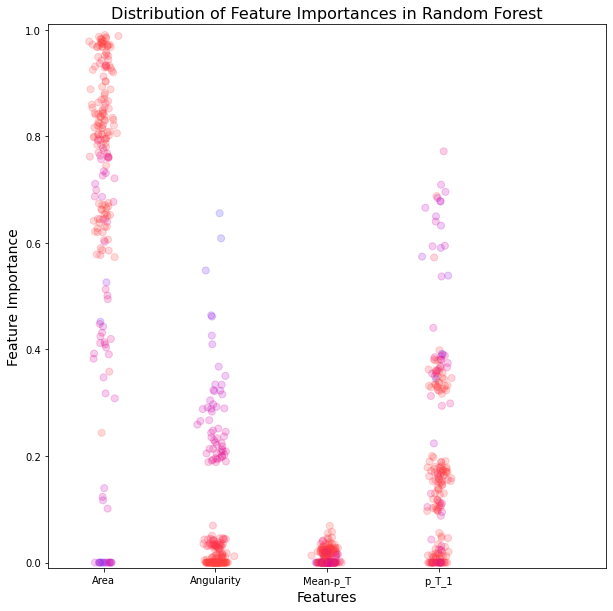

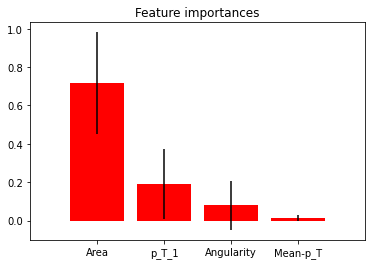

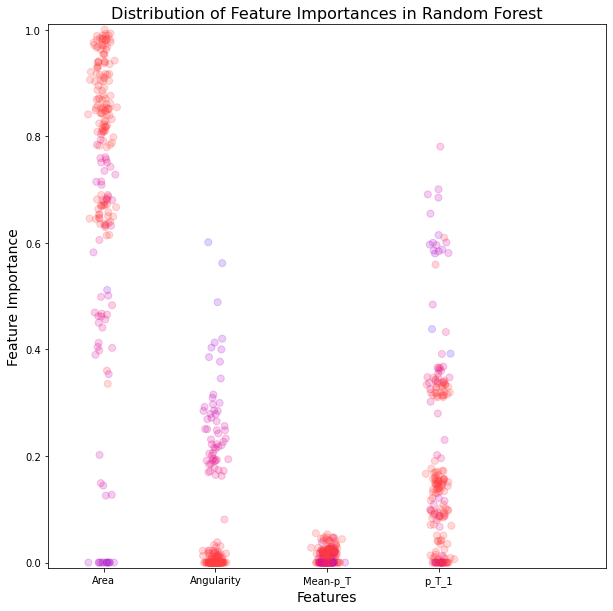

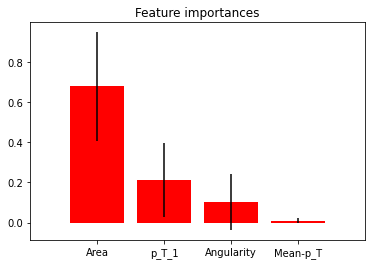

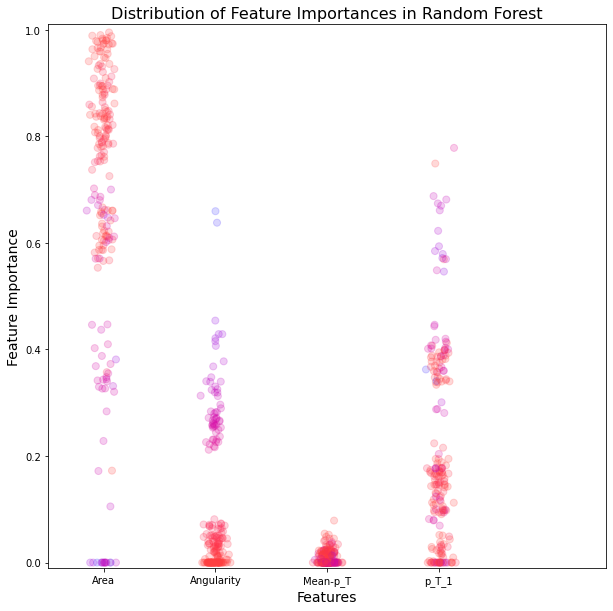

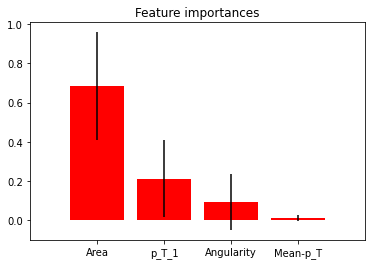

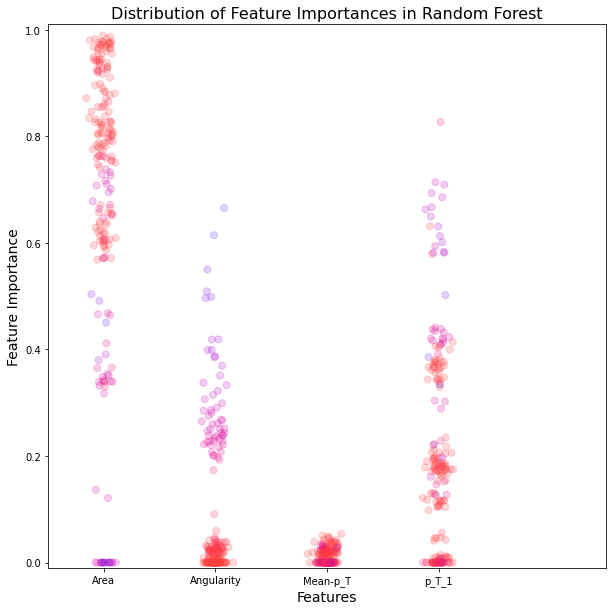

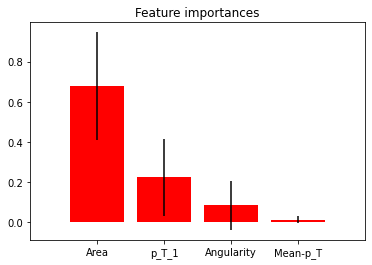

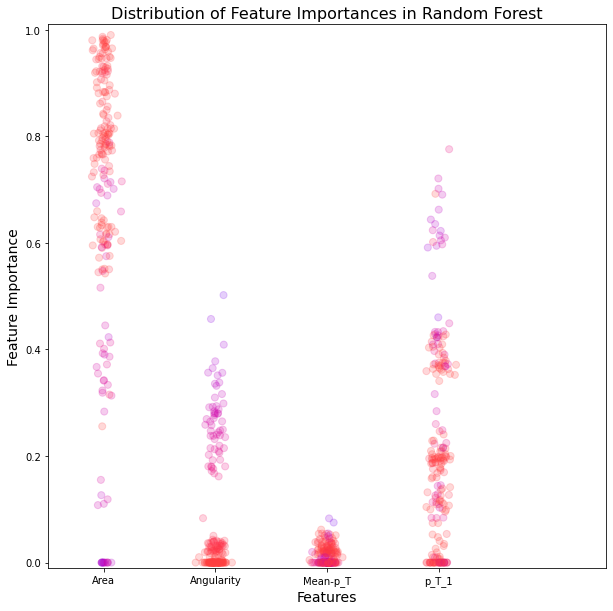

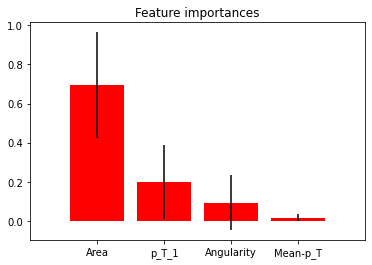

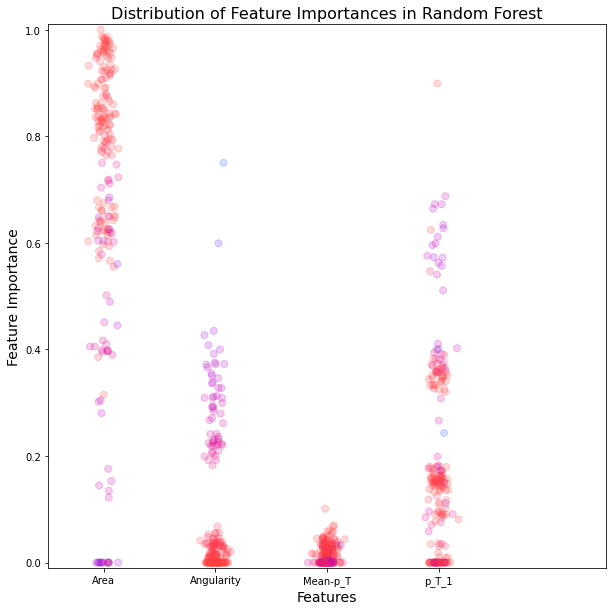

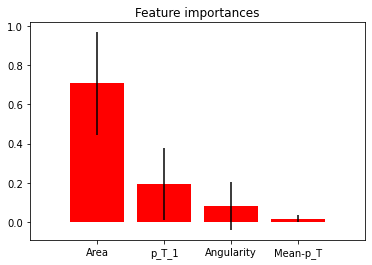

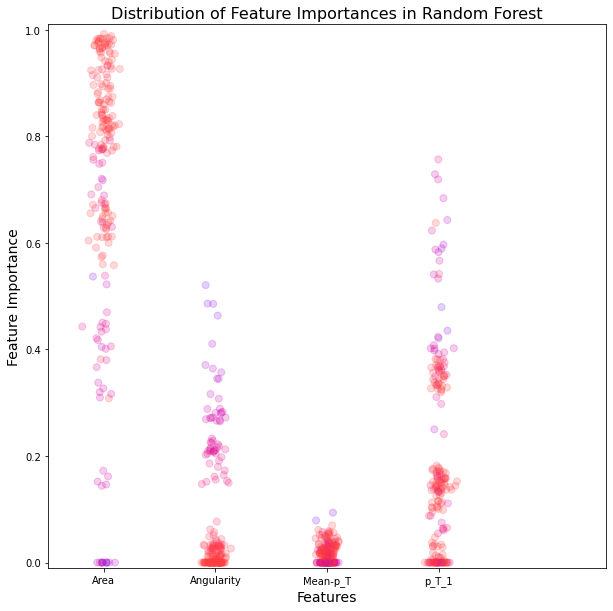

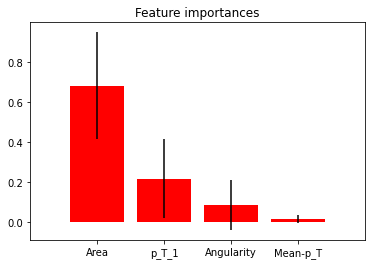

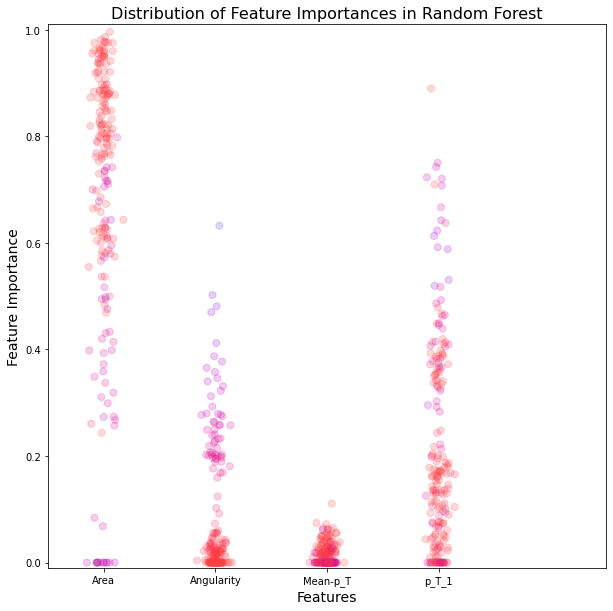

In [ ]:
feat_imps = []
model_no=0

ave_perf_metrics = {}

for model in rfModel:
    feat_imp = {}
    perf_metrics = doModelEvaluation(X, Y, Xtest, Ytest, model, rad, ptm, feat_imp,False, model_no)
    
    if model_no==0:
        ave_perf_metrics=perf_metrics
    else:
        for key in ave_perf_metrics.keys():
            ave_perf_metrics[key] = [old+new for old, new in zip(ave_perf_metrics[key], perf_metrics[key])]
    feat_imps.append(feat_imp[f'pthard={ptm}'][1])
    model_no+=1
ave_perf_metrics = {key:list(map(lambda x:x/(model_no+1), value)) for (key, value) in zip(ave_perf_metrics.keys(),ave_perf_metrics.values())}
print(f"Average Performance Metrics:{ave_perf_metrics}")
text_results[f"R{rad}pt{ptm}"]['ave_perf_metrics'] = ave_perf_metrics
text_results[f"R{rad}pt{ptm}"]['ave_feat_imps'] = np.mean(feat_imps, axis=0)
print(np.mean(feat_imps, axis=0))



In [ ]:
if low_pt:
    feat_imps_lowpt = []
    model_no=0
    ave_perf_metrics_low = {}
    for model in rfModelLowpt:
        feat_imp = {}
        perf_metrics_low = doModelEvaluation(XLowpt, YLowpt, XtestLowpt, YtestLowpt, model, rad, ptm, feat_imp, True, model_no)
        if model_no==0:
            ave_perf_metrics_low=perf_metrics_low
        else:
            for key in ave_perf_metrics_low.keys():
                ave_perf_metrics_low[key]+=perf_metrics_low[key]
        feat_imps_lowpt.append(feat_imp)
        model_no+=1
    ave_perf_metrics_low = {key:value/(model_no+1) for (key, value) in zip(ave_perf_metrics_low.keys(), ave_perf_metrics_low.values())}
    print(f"Average Performance Metrics:{ave_perf_metrics_low}")
    text_results[f"R{rad}pt{ptm}"]['ave_perf_metrics_low'] = ave_perf_metrics_low
    text_results[f"R{rad}pt{ptm}"]['feat_imps_low'] = feat_imps_lowpt
    print(feat_imps_lowpt)

In [ ]:
# Top cuts and effect
names = X.columns
print([names[x] for x in oracle.tree_.feature])
print(oracle.tree_.threshold)

top_feat = names[oracle.tree_.feature[0]]
top_thresh = oracle.tree_.threshold[0]
print(f"{top_feat} <= {top_thresh}")
key_names = train['Label_Name'].unique()
jet_vals = dict(zip(key_names, oracle.tree_.value[0][0]))
lt_jet_vals = dict(zip(key_names, oracle.tree_.value[oracle.tree_.children_left[0]][0]))
rt_jet_vals = dict(zip(key_names, oracle.tree_.value[oracle.tree_.children_right[0]][0]))



print(f"Vals: {jet_vals}, lt_vals: {lt_jet_vals}, rt_vals: {rt_jet_vals}")
print()

rejection_rates = [100*lt_jet_vals[lbl]/jet_vals[lbl] for lbl in key_names]
retention_rates = [100*rt_jet_vals[lbl]/jet_vals[lbl] for lbl in key_names]

print(f"{rejection_rates=}, {retention_rates=}")

rejection_string = ", ".join([f"{rt:2.1f}% of our {name} jets" for rt, name in zip(rejection_rates, key_names)])
retention_string = ", ".join([f"{rt:2.1f}% of our {name} jets" for rt, name in zip(retention_rates, key_names)])

lt_string = f"{top_feat} <= {top_thresh:2.3f} keeps {rejection_string}"

rt_string = f"{top_feat} > {top_thresh:2.3f} keeps {retention_string}"

print(lt_string)
print()
print(rt_string)


text_results[f"R{rad}pt{ptm}"]["top_cut"] = (top_feat, top_thresh)
text_results[f"R{rad}pt{ptm}"]["top_cut_strings"] = (lt_string, rt_string)

['Area', 'p_T_1', 'Area', 'Mean-p_T', 'Mean-p_T', 'Area', 'Mean-p_T', 'Mean-p_T', 'Angularity', 'Area', 'Mean-p_T', 'Mean-p_T', 'Area', 'Mean-p_T', 'Mean-p_T']
[ 0.0977284   3.01618505  0.09672605 -2.         -2.          0.07768155
 -2.         -2.          0.1115275   0.10274    -2.         -2.
  0.09873075 -2.         -2.        ]
Area <= 0.09772840142250061
Vals: {'Fake': 782850.0, 'Has p_T from Pythia': 1105286.0}, lt_vals: {'Fake': 771335.0, 'Has p_T from Pythia': 22296.0}, rt_vals: {'Fake': 11515.0, 'Has p_T from Pythia': 1082990.0}

rejection_rates=[98.52909241872645, 2.017215453737766], retention_rates=[1.4709075812735517, 97.98278454626224]
Area <= 0.098 keeps 98.5% of our Fake jets, 2.0% of our Has p_T from Pythia jets

Area > 0.098 keeps 1.5% of our Fake jets, 98.0% of our Has p_T from Pythia jets


In [ ]:
# Top cuts and effect
if low_pt:
    names = XLowpt.columns
    print([names[x] for x in oracleLowpt.tree_.feature])
    print(oracleLowpt.tree_.threshold)

    top_feat = names[oracleLowpt.tree_.feature[0]]
    top_thresh = oracleLowpt.tree_.threshold[0]
    print(f"{top_feat} <= {top_thresh}")
    key_names = ["Fake", "Squishy", "Real"]
    jet_vals = dict(zip(key_names, oracleLowpt.tree_.value[0][0]))
    lt_jet_vals = dict(zip(key_names, oracleLowpt.tree_.value[oracleLowpt.tree_.children_left[0]][0]))
    rt_jet_vals = dict(zip(key_names, oracleLowpt.tree_.value[oracleLowpt.tree_.children_right[0]][0]))
    print(f"Vals: {jet_vals}, lt_vals: {lt_jet_vals}, rt_vals: {rt_jet_vals}")
    print()

    if len(lt_jet_vals)<3 or len(rt_jet_vals)<3:
        pass
    else:
        fake_jet_rejection_low = 100*lt_jet_vals['Fake']/jet_vals['Fake']
        squishy_jet_rejection_low = 100*lt_jet_vals['Squishy']/jet_vals['Squishy']
        real_jet_rejection_low = 100*lt_jet_vals['Real']/jet_vals['Real']

        fake_jet_retention_low = 100*rt_jet_vals['Fake']/jet_vals['Fake']
        squishy_jet_retention_low = 100*rt_jet_vals['Squishy']/jet_vals['Squishy']
        real_jet_retention_low = 100*rt_jet_vals['Real']/jet_vals['Real']

        lt_string = f"{top_feat} <= {top_thresh:2.3f} keeps {fake_jet_rejection_low:2.2f}% of our Fake jets, {squishy_jet_rejection:2.2f}% of our Squishy jets, and {real_jet_rejection_low:2.2f}% of our Real jets"


        rt_string = f"{top_feat} > {top_thresh:2.3f} keeps {fake_jet_retention_low:2.2f}% of our Fake jets, {squishy_jet_retention_low:2.2f}% of our Squishy jets, and {real_jet_retention_low:2.2f}% of our Real jets"

        print(lt_string)
        print()
        print(rt_string)



        text_results[f"R{rad}pt{ptm}"]["top_cut_strings_low"] = (lt_string, rt_string)

In [ ]:
import pprint
import pickle
pp = pprint.PrettyPrinter(depth=6)
pp.pprint(text_results)
if rad==0.6 and ptm==40:
    print("We made it! Let's save the data.")
    pickle.dump(text_results, open("NumericalData.pickle", "wb"))

{'R0.2pt10': {'ave_feat_imps': array([0.69148932, 0.08716712, 0.01376371, 0.20757985]),
              'ave_perf_metrics': {'population_rates_test': [0.4366278823599149,
                                                             0.5825325622413675],
                                   'population_rates_train': [0.43732126152258644,
                                                              0.5841580802961994]},
              'ave_rf_acc': 0.5661449528353183,
              'oracle_acc': 0.5662664130126219,
              'pca': [(0.99117076,
                       {'Angularity': -0.0005674958,
                        'Area': 0.009739979,
                        'Mean-p_T': 0.046603203,
                        'p_T_1': 0.99886596}),
                      (0.00796392,
                       {'Angularity': 0.0027718886,
                        'Area': 0.0006896204,
                        'Mean-p_T': -0.99890953,
                        'p_T_1': 0.046600085}),
                      (0.00

In [ ]:
from matplotlib.patches import Rectangle
from matplotlib.text import Annotation

In [ ]:
fig, ax = plt.subplots()
ax.set_xticklabels([])
ax.set_yticklabels([])

ax.set_title(f'{top_feat} > {top_thresh}')

real_h = Rectangle((0, 2/3), real_jet_retention/100, 1/3, facecolor='None', edgecolor='k')
real_bg = Rectangle((0, 2/3), real_jet_retention/100, 1/3, color='darkseagreen')
real_border = Rectangle((0, 2/3), 1, 1/3, edgecolor='k', facecolor='None')

ax.annotate("Real", (-0.05, 4/6), xycoords=('axes fraction', 'figure fraction'), ha='right')
ax.annotate(f"{real_jet_retention:2.2f}%", (real_jet_retention/100/2, 4/6), xycoords=('axes fraction', 'figure fraction'), ha='center')


squishy_h = Rectangle((0, 1/3), squishy_jet_retention/100, 1/3, facecolor='None', edgecolor='k')
squishy_bg = Rectangle((0, 1/3), squishy_jet_retention/100, 1/3, color='coral')
squishy_border = Rectangle((0, 1/3), 1, 1/3, edgecolor='k', facecolor='None')

ax.annotate("Squishy", (-0.05, 2.5/6), xycoords=('axes fraction', 'figure fraction'), ha='right')
ax.annotate(f"{squishy_jet_retention:2.2f}%", (squishy_jet_retention/100/2, 2.5/6), xycoords=('axes fraction', 'figure fraction'), ha='center')

fake_h = Rectangle((0, 0), fake_jet_retention/100, 1/3, facecolor='None', edgecolor='k')
fake_bg = Rectangle((0, 0), fake_jet_retention/100, 1/3, color='powderblue')
fake_border = Rectangle((0, 0), 1, 1/3, edgecolor='k', facecolor='None')

ax.annotate("Fake", (-0.05, 1/6), xycoords=('axes fraction', 'figure fraction'), ha='right')
ax.annotate(f"{fake_jet_retention:2.2f}%", (fake_jet_retention/100/2, 1/6), xycoords=('axes fraction', 'figure fraction'), ha='center')

ax.add_patch(real_bg)
ax.add_patch(real_h)
ax.add_patch(real_border)

ax.add_patch(squishy_bg)
ax.add_patch(squishy_h)
ax.add_patch(squishy_border)

ax.add_patch(fake_bg)
ax.add_patch(fake_h)
ax.add_patch(fake_border)

filename = f'slide_plots/R{rad}pt{ptm}_cut_stats.png'
fig.savefig(filename, dpi=150)


NameError: name 'real_jet_retention' is not defined

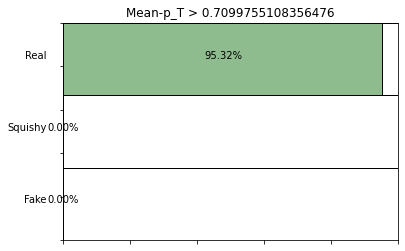

In [ ]:
fig, ax = plt.subplots()
ax.set_xticklabels([])
ax.set_yticklabels([])

ax.set_title(f'{top_feat} > {top_thresh}')

real_h = Rectangle((0, 2/3), real_jet_retention_low/100, 1/3, facecolor='None', edgecolor='k')
real_bg = Rectangle((0, 2/3), real_jet_retention_low/100, 1/3, color='darkseagreen')
real_border = Rectangle((0, 2/3), 1, 1/3, edgecolor='k', facecolor='None')

ax.annotate("Real", (-0.05, 4/6), xycoords=('axes fraction', 'figure fraction'), ha='right')
ax.annotate(f"{real_jet_retention_low:2.2f}%", (real_jet_retention_low/100/2, 4/6), xycoords=('axes fraction', 'figure fraction'), ha='center')


squishy_h = Rectangle((0, 1/3), squishy_jet_retention_low/100, 1/3, facecolor='None', edgecolor='k')
squishy_bg = Rectangle((0, 1/3), squishy_jet_retention_low/100, 1/3, color='coral')
squishy_border = Rectangle((0, 1/3), 1, 1/3, edgecolor='k', facecolor='None')

ax.annotate("Squishy", (-0.05, 2.5/6), xycoords=('axes fraction', 'figure fraction'), ha='right')
ax.annotate(f"{squishy_jet_retention_low:2.2f}%", (squishy_jet_retention_low/100/2, 2.5/6), xycoords=('axes fraction', 'figure fraction'), ha='center')

fake_h = Rectangle((0, 0), fake_jet_retention_low/100, 1/3, facecolor='None', edgecolor='k')
fake_bg = Rectangle((0, 0), fake_jet_retention_low/100, 1/3, color='powderblue')
fake_border = Rectangle((0, 0), 1, 1/3, edgecolor='k', facecolor='None')

ax.annotate("Fake", (-0.05, 1/6), xycoords=('axes fraction', 'figure fraction'), ha='right')
ax.annotate(f"{fake_jet_retention_low:2.2f}%", (fake_jet_retention_low/100/2, 1/6), xycoords=('axes fraction', 'figure fraction'), ha='center')

ax.add_patch(real_bg)
ax.add_patch(real_h)
ax.add_patch(real_border)

ax.add_patch(squishy_bg)
ax.add_patch(squishy_h)
ax.add_patch(squishy_border)

ax.add_patch(fake_bg)
ax.add_patch(fake_h)
ax.add_patch(fake_border)

filename = f'slide_plots/R{rad}pt{ptm}_cut_stats_low.png'
fig.savefig(filename, dpi=150)


[0.00462142 0.0936215  0.40138719 0.50036988]


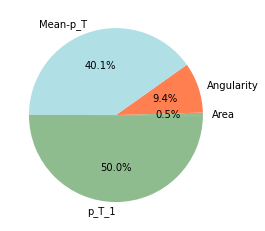

In [ ]:
fig, ax = plt.subplots()

sizes = text_results[f"R{rad}pt{ptm}"]['ave_feat_imps'][0][f'pthard={ptm}'][1]
print(sizes)
labels=text_results[f"R{rad}pt{ptm}"]['ave_feat_imps'][0][f'pthard={ptm}'][0]
ax.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['darkseagreen', 'coral', 'powderblue'])
filename = f'slide_plots/R{rad}pt{ptm}_featimp_pie.png'
fig.savefig(filename, dpi=150)


[0.00567088 0.0852604  0.40723793 0.50183079]
<ipython-input-44-21d0248b4814>:6: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  ax.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['darkseagreen', 'coral', 'powderblue'])


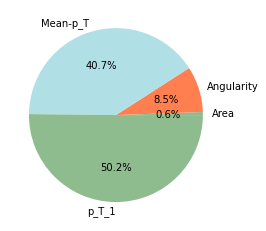

In [ ]:
fig, ax = plt.subplots()

sizes = text_results[f"R{rad}pt{ptm}"]['feat_imps_low'][0][f'pthard={ptm}'][1]
print(sizes)
labels=text_results[f"R{rad}pt{ptm}"]['feat_imps_low'][0][f'pthard={ptm}'][0]
ax.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['darkseagreen', 'coral', 'powderblue'])
filename = f'slide_plots/R{rad}pt{ptm}_featimp_pie_low.png'
fig.savefig(filename, dpi=150)